# Daily Stop Grain Exploration

1. Make sure that `avg_prediction_error_sec` matches up with how a prediction is categorized as `early/on_time/late`, and make sure those seconds have the right signs.
1. Make sure that `early/on_time/late` metrics make sense with `pct_accuracy`
1. Deeper dive into the "accuracy" exponential curve. See if we can use this as "expected wait time" metric.

In [1]:
import altair as alt
import pandas as pd

import prep_data
from rt_msa_utils import PREDICTIONS_GCS, RT_MSA_DICT

alt.data_transformers.enable("vegafusion")

DOWNLOAD_DICT = RT_MSA_DICT.rt_trip_updates_downloads

## Daily Stop Grain
### Avg prediction error seconds is positive for bus arriving after prediction says (prediction is **earlier** than actual)
* yes, the sign direction is correct
* we will want to remove outliers, maybe anything above a certain threshold of minutes (here, it's 1% or less for outliers)

In [2]:
FILE = RT_MSA_DICT.rt_trip_updates_downloads.daily_stop_grain

daily_df = pd.read_parquet(
    f"{PREDICTIONS_GCS}{FILE}.parquet"
)

daily_df.dtypes

key                                      object
stop_key                                 object
base64_url                               object
service_date                     datetime64[ns]
stop_id                                  object
schedule_feed_key                        object
avg_prediction_error_sec                float64
n_tu_accurate_minutes                     Int64
n_tu_complete_minutes                     Int64
n_tu_minutes_available                    Int64
avg_prediction_spread_minutes           float64
n_predictions                             Int64
n_predictions_early                       Int64
n_predictions_ontime                      Int64
n_predictions_late                        Int64
n_tu_trips                                Int64
dtype: object

In [3]:
daily_df = prep_data.calculate_percents(daily_df)

daily_df[prep_data.PREDICTION_ERROR_COLS].describe(
    percentiles = prep_data.PERCENTILE_LIST)

,avg_prediction_error_sec,pct_tu_predictions_early,pct_tu_predictions_ontime,pct_tu_predictions_late
count,926463.000000,942162.0,942162.0,942162.0
mean,49.187435,0.631339,0.03902,0.302079
std,123.158659,0.197401,0.107054,0.161343
min,-22509.692308,0.0,0.0,0.0
1%,-185.920227,0.0,0.0,0.0
5%,-46.243339,0.25,0.0,0.05
10%,-15.833333,0.39,0.0,0.11
25%,21.045454,0.53,0.01,0.19
50%,55.886665,0.67,0.01,0.29
75%,85.399978,0.77,0.02,0.4


In [4]:
daily_df2 = prep_data.drop_outliers(
    daily_df, prep_data.MIN_ERROR_SEC, prep_data.MAX_ERROR_SEC
)

daily_df2[prep_data.PREDICTION_ERROR_COLS].describe(
    percentiles = prep_data.PERCENTILE_LIST
)

,avg_prediction_error_sec,pct_tu_predictions_early,pct_tu_predictions_ontime,pct_tu_predictions_late
count,914559.000000,914559.0,914559.0,914559.0
mean,51.468511,0.643398,0.039625,0.306053
std,56.734082,0.178116,0.108301,0.154067
min,-250.000000,0.0,0.0,0.0
1%,-130.567398,0.01,0.0,0.0
5%,-40.838048,0.32,0.0,0.08
10%,-13.808901,0.41,0.0,0.12
25%,21.653752,0.54,0.01,0.2
50%,55.896078,0.67,0.01,0.29
75%,84.969749,0.77,0.02,0.4


In [5]:
# Look at observations with high pct late
round(len(daily_df2[(daily_df2.pct_tu_predictions_late >= 0.5)]) / len(daily_df2), 3)

0.119

<Axes: >

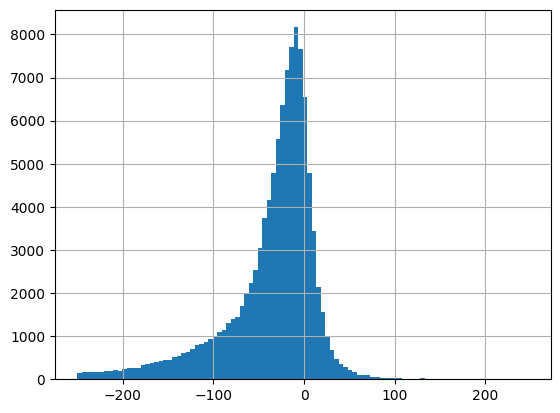

In [6]:
daily_df2[(daily_df2.pct_tu_predictions_late >= 0.5)].avg_prediction_error_sec.hist(bins=100)

<Axes: >

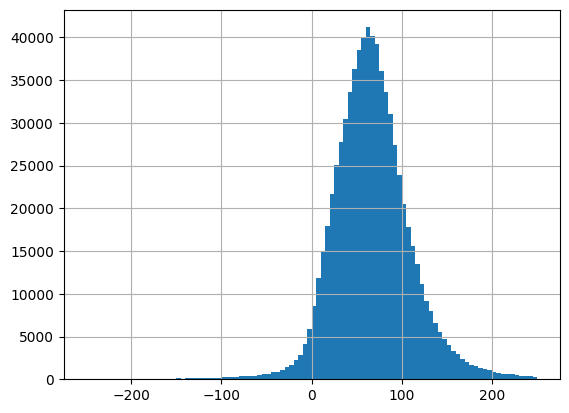

In [7]:
daily_df2[(daily_df2.pct_tu_predictions_early >= 0.5)].avg_prediction_error_sec.hist(bins=100)

In [8]:
daily_df[prep_data.ACCURACY_COLS].describe(
    percentiles=prep_data.PERCENTILE_LIST)

,pct_tu_accurate_minutes,pct_tu_predictions_ontime
count,942162.0,942162.0
mean,0.749586,0.03902
std,0.172775,0.107054
min,0.0,0.0
1%,0.0,0.0
5%,0.41,0.0
10%,0.56,0.0
25%,0.7,0.01
50%,0.79,0.01
75%,0.85,0.02


In [9]:
# These behave in the normal range, so we're only dropping outliers on avg_prediction_error_sec
# not much difference in these distributions
daily_df2[prep_data.ACCURACY_COLS].describe(percentiles=prep_data.PERCENTILE_LIST)

,pct_tu_accurate_minutes,pct_tu_predictions_ontime
count,914559.0,914559.0
mean,0.767459,0.039625
std,0.135172,0.108301
min,0.0,0.0
1%,0.33,0.0
5%,0.5,0.0
10%,0.59,0.0
25%,0.71,0.01
50%,0.79,0.01
75%,0.86,0.02


## Stops Aggregated by Day Type
### Avg prediction error seconds is positive for early arrivals

In [10]:
FILE = RT_MSA_DICT.rt_schedule_models.weekday_stop_grain

daytype_df = pd.read_parquet(
    f"{PREDICTIONS_GCS}{FILE}.parquet",   
)

daytype_df[prep_data.PREDICTION_ERROR_COLS].describe(
    percentiles=prep_data.PERCENTILE_LIST)

,avg_prediction_error_sec,pct_tu_predictions_early,pct_tu_predictions_ontime,pct_tu_predictions_late
count,1.742386e+06,1.764792e+06,1.764792e+06,1.764792e+06
mean,4.732094e+01,6.312258e-01,3.748932e-02,3.073510e-01
std,1.203496e+02,1.711195e-01,9.187022e-02,1.366724e-01
min,-2.097112e+04,0.000000e+00,0.000000e+00,0.000000e+00
1%,-1.613084e+02,0.000000e+00,0.000000e+00,0.000000e+00
5%,-3.716826e+01,3.000000e-01,0.000000e+00,1.000000e-01
10%,-7.003360e+00,4.200000e-01,1.000000e-02,1.500000e-01
25%,2.773828e+01,5.600000e-01,1.000000e-02,2.200000e-01
50%,5.419504e+01,6.700000e-01,1.000000e-02,3.000000e-01
75%,7.792475e+01,7.400000e-01,2.000000e-02,3.800000e-01


In [11]:
daytype_df.avg_prediction_error_sec.min(), daytype_df.avg_prediction_error_sec.max()

(-20971.125, 1188.6239734933854)

In [12]:
daytype_df2 = prep_data.drop_outliers(
    daytype_df, prep_data.MIN_ERROR_SEC, prep_data.MAX_ERROR_SEC
)

daytype_df2[prep_data.PREDICTION_ERROR_COLS].describe(
    percentiles=prep_data.PERCENTILE_LIST)

,avg_prediction_error_sec,pct_tu_predictions_early,pct_tu_predictions_ontime,pct_tu_predictions_late
count,1.727213e+06,1.727213e+06,1.727213e+06,1.727213e+06
mean,4.989460e+01,6.410566e-01,3.796528e-02,3.096397e-01
std,4.924638e+01,1.533830e-01,9.267598e-02,1.289014e-01
min,-2.499416e+02,0.000000e+00,0.000000e+00,0.000000e+00
1%,-1.184392e+02,1.100000e-01,0.000000e+00,2.000000e-02
5%,-3.224838e+01,3.500000e-01,0.000000e+00,1.200000e-01
10%,-5.213724e+00,4.500000e-01,1.000000e-02,1.600000e-01
25%,2.826944e+01,5.700000e-01,1.000000e-02,2.200000e-01
50%,5.430531e+01,6.700000e-01,1.000000e-02,3.000000e-01
75%,7.781720e+01,7.400000e-01,2.000000e-02,3.800000e-01


<Axes: >

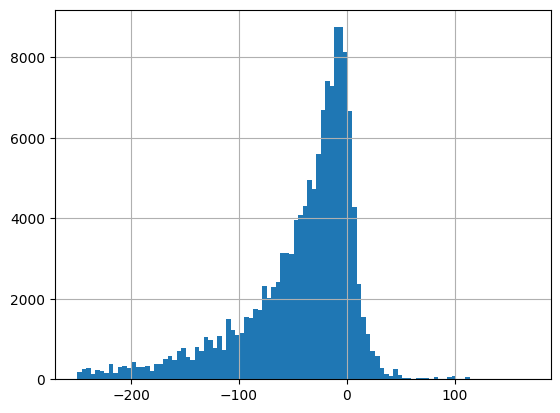

In [13]:
daytype_df2[(daytype_df2.pct_tu_predictions_late >= 0.5)].avg_prediction_error_sec.hist(bins=100)

<Axes: >

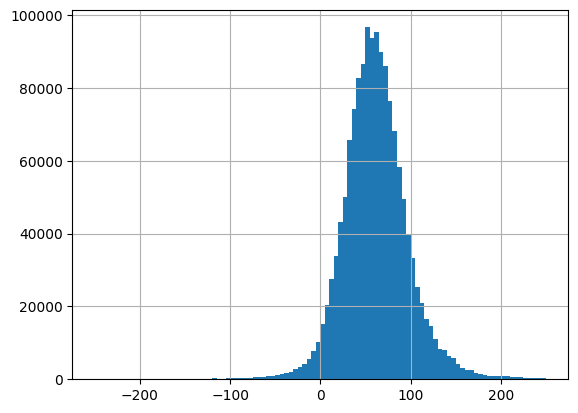

In [14]:
daytype_df2[(daytype_df2.pct_tu_predictions_early >= 0.5)].avg_prediction_error_sec.hist(bins=100)

In [15]:
daytype_df2[prep_data.ACCURACY_COLS].describe(
    percentiles=prep_data.PERCENTILE_LIST)

,pct_tu_accurate_minutes,pct_tu_predictions_ontime
count,1.727213e+06,1.727213e+06
mean,7.699415e-01,3.796528e-02
std,1.205612e-01,9.267598e-02
min,0.000000e+00,0.000000e+00
1%,3.500000e-01,0.000000e+00
5%,5.300000e-01,0.000000e+00
10%,6.300000e-01,1.000000e-02
25%,7.300000e-01,1.000000e-02
50%,7.900000e-01,1.000000e-02
75%,8.500000e-01,2.000000e-02
